In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis




In [3]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


In [4]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)
df = df.drop_duplicates()

number of duplicate rows:  (3854, 9)


In [5]:
# Loop through each column and count the number of distinct values
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [6]:
# Checking null values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [7]:
# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

In [8]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


In [9]:
df = df.drop("HbA1c_level", axis = 1)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,140,0
1,Female,54.00,0,0,No Info,27.32,80,0
2,Male,28.00,0,0,never,27.32,158,0
3,Female,36.00,0,0,current,23.45,155,0
4,Male,76.00,1,1,current,20.14,155,0


In [10]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 1
    elif smoking_status == 'current':
        return 2
    elif smoking_status in ['ever', 'former', 'not current']:
        return 3

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

1    67276
3    19655
2     9197
Name: smoking_history, dtype: int64


In [11]:
# Define a function to map the existing categories to new ones
def recategorize_gender(gender_status):
    if gender_status == 'Male':
        return 1
    elif gender_status == 'Female':
        return 0

# Apply the function to the 'smoking_history' column
df['gender'] = df['gender'].apply(recategorize_gender)

# Check the new value counts
print(df['gender'].value_counts())

0    56161
1    39967
Name: gender, dtype: int64


In [12]:
# Create a new column in the DataFrame for the new feature
glucose_level_column = df["blood_glucose_level"]
df["voltage_ratio"] = -0.276*glucose_level_column + 94.882
df = df.drop("blood_glucose_level", axis=1)
df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes,voltage_ratio
0,0,80.00,0,1,1,25.19,0,56.24
1,0,54.00,0,0,1,27.32,0,72.80
2,1,28.00,0,0,1,27.32,0,51.27
3,0,36.00,0,0,2,23.45,0,52.10
4,1,76.00,1,1,2,20.14,0,52.10


In [13]:
df = df[['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'voltage_ratio', 'diabetes']]

print(df)

       gender   age  hypertension  heart_disease  smoking_history   bmi  \
0           0 80.00             0              1                1 25.19   
1           0 54.00             0              0                1 27.32   
2           1 28.00             0              0                1 27.32   
3           0 36.00             0              0                2 23.45   
4           1 76.00             1              1                2 20.14   
...       ...   ...           ...            ...              ...   ...   
99994       0 36.00             0              0                1 24.60   
99996       0  2.00             0              0                1 17.37   
99997       1 66.00             0              0                3 27.83   
99998       0 24.00             0              0                1 35.42   
99999       0 57.00             0              0                2 22.43   

       voltage_ratio  diabetes  
0              56.24         0  
1              72.80         0  


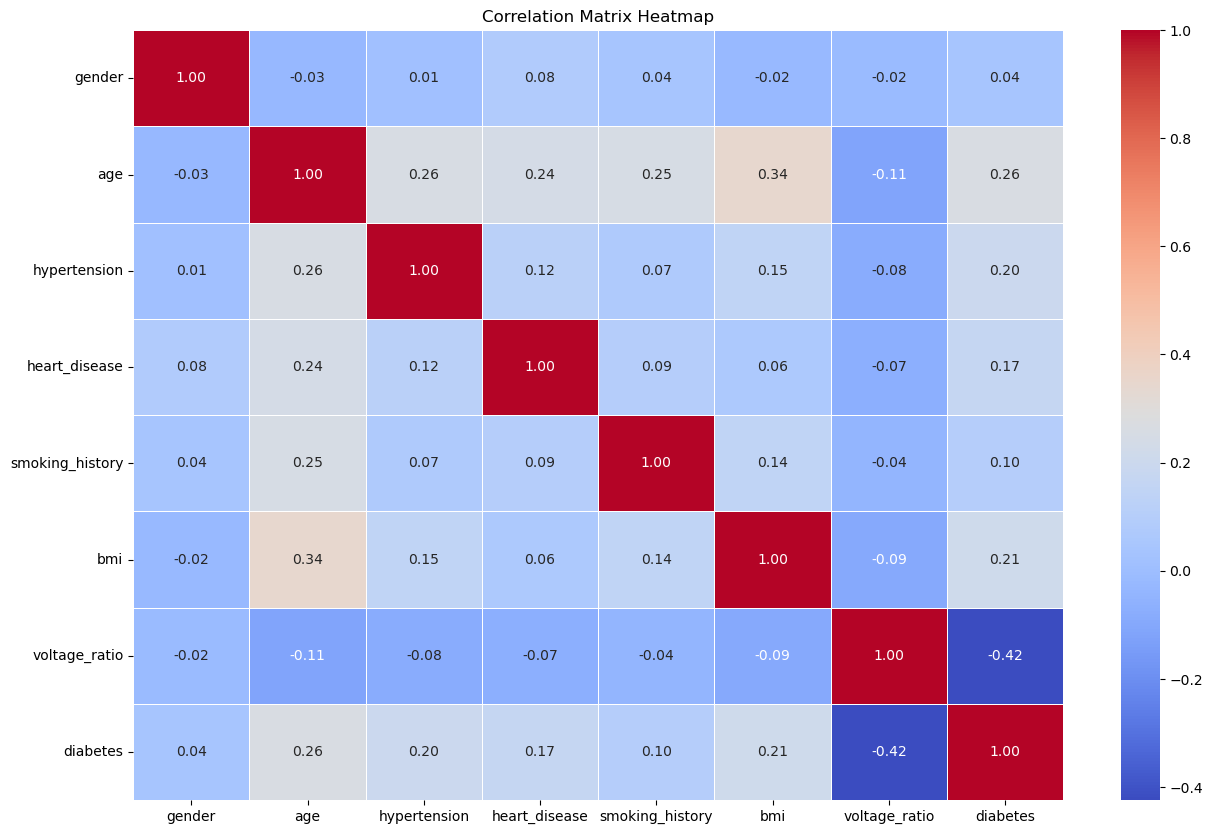

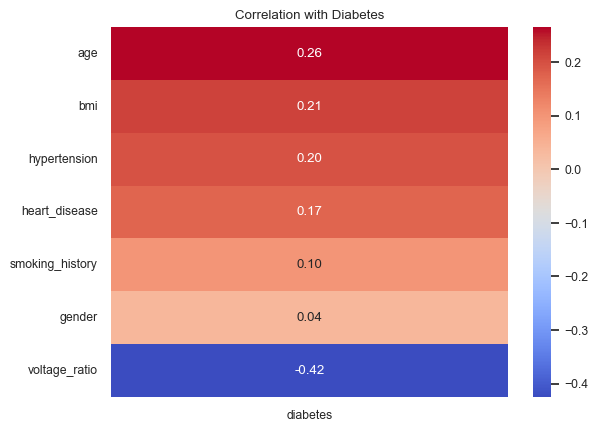

In [14]:
# Compute the correlation matrix
correlation_matrix = df.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = df.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

In [15]:
df_new = df.copy()

In [16]:
# Split data into features and target variable
X = df_new[['voltage_ratio', 'bmi', 'age']]
y = df_new['diabetes']

In [17]:
# Define resampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)

In [18]:
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [19]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test= standard_scaler.transform(X_test)


In [20]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.701 total time= 2.3min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.699 total time= 2.4min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time= 2.4min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.698 total time= 5.5min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.698 total time= 3.7min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.844 total time=  54.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.833 total time=  55.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.839 total time=  54.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.838 total time= 1.0min
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.838 total time= 1.0min
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.844 total time=  32.6s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

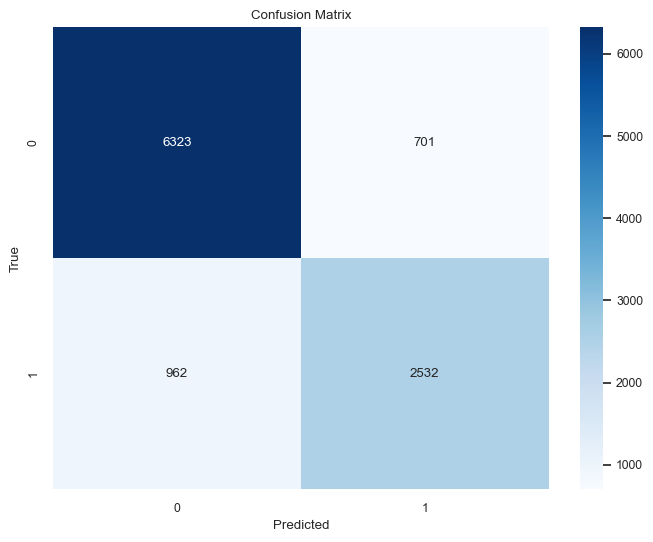

In [21]:
# Create Grid Search object
model = SVC()
grid_search = GridSearchCV(model, param_grid, refit = True, verbose = 3)

# Split data into train and test sets
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)
y_pred_train = grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
print('Training accuracy:', train_accuracy)
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("precision: ",precision)
print("recall: ",recall)

precision:  0.7831735230436128
recall:  0.7246708643388666


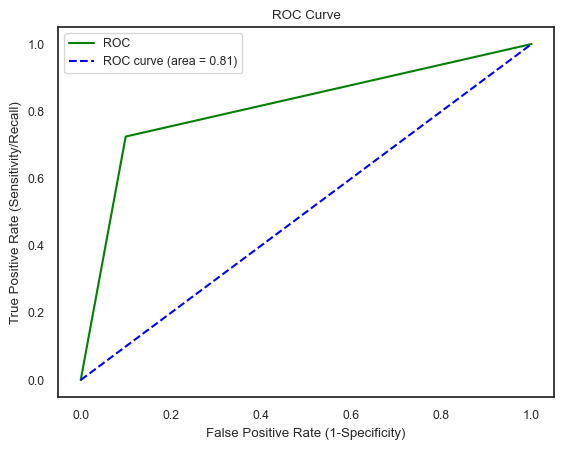

In [23]:
#PLOTTING GRAPH for model 1
#ROC curve
from sklearn.metrics import roc_auc_score,roc_curve

roc_auc_score(y_test,y_pred)
roc_curve(y_test,y_pred)
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

**VALIDATION**

In [ ]:
dn = pd.read_csv('DIABETES DATASETcsv')
dn.head()

In [ ]:
# Create a new column in the DataFrame for the new feature
glucose_level_column = dn["Glucose"]
dn["voltage_ratio"] = -0.276*glucose_level_column + 94.882
dn = dn.drop("Glucose", axis=1)
dn.head(5)

In [ ]:
dn = dn.rename(columns = {'Age':'age','BMI':'bmi','Outcome' : 'diabetes'})
dn.head()

In [ ]:
dn = dn[['age' ,'bmi', 'voltage_ratio', 'diabetes']]

print(dn)

In [ ]:
X_val = dn[['voltage_ratio', 'bmi', 'age']]
y_val = dn['diabetes']

In [ ]:
# Predict on the test set using the best model
validation = model.predict(X_val)

cm = confusion_matrix(y_val, validation)

# Evaluate the model
print("Validation Accuracy: ", accuracy_score(y_val, validation))
print(classification_report(y_val, validation))